## Описание задачи: 
Команда приложения для знакомств разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма провели A/B-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Пользователи в группе №1 пользовались приложением с новым алгоритмом для поиска анкет.
Необходимо оценить, действительно ли новый алгоритм улучшил качество сервиса. 

### Описание данных:
- `user_id_1` – уникальный идентификатор пользователя (старый алгоритм).
- `user_id_2` – уникальный идентификатор пользователя (новый алгоритм).
- `group` - номер группы.
- `is_match` - мэтч (0 - нет мэтча, 1 - есть мэтч).

### Ход исследования:
1. Загрузка данных + препроцессинг при необходимости.
2. Проверка гипотез.
3. Выводы.

In [1]:
import pandas as pd
from scipy import stats

import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/cKCxLr_dTb2KJA'

# загрузочная ссылка
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# файл и его сохранение
download_response = requests.get(download_url)
with open('dating_data.csv', 'wb') as f:
    f.write(download_response.content)

In [3]:
df = pd.read_csv('dating_data.csv')

In [4]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


#### Гипотеза 1: существуют различия в средней доле мэтчей среди двух алгоритмов.

- $H_0$: средние в группах не имеют различий
- $H_1$: средние в группах отличаются

In [5]:
# расчет средней доли мэтчей в группе 0
group0_match = df.loc[df['group']==0].groupby('user_id_1', as_index=False)\
                 .agg(is_match_sum=('is_match', 'sum'), is_match_count=('is_match', 'count'))\
                 .round(2).rename(columns={'is_match':'match_per_user'})
group0_match['match_per_user'] = round(group0_match['is_match_sum'] / group0_match['is_match_count'], 2)
mean_match_g0 = group0_match['match_per_user'].mean()
print(f'Средняя доля мэтчей в группе 0: {mean_match_g0:.2f}')

Средняя доля мэтчей в группе 0: 0.19


In [6]:
# # расчет средней доли мэтчей в группе 1
group1_match = df.loc[df['group']==1].groupby('user_id_1', as_index=False)\
                  .agg(is_match_sum=('is_match', 'sum'), is_match_count=('is_match', 'count'))\
                  .round(2).rename(columns={'is_match':'match_per_user'})
group1_match['match_per_user'] = round(group1_match['is_match_sum'] / group1_match['is_match_count'], 2)
mean_match_g1 = group1_match['match_per_user'].mean()
print(f'Средняя доля мэтчей в группе 1: {mean_match_g1:.2f}')

Средняя доля мэтчей в группе 1: 0.40


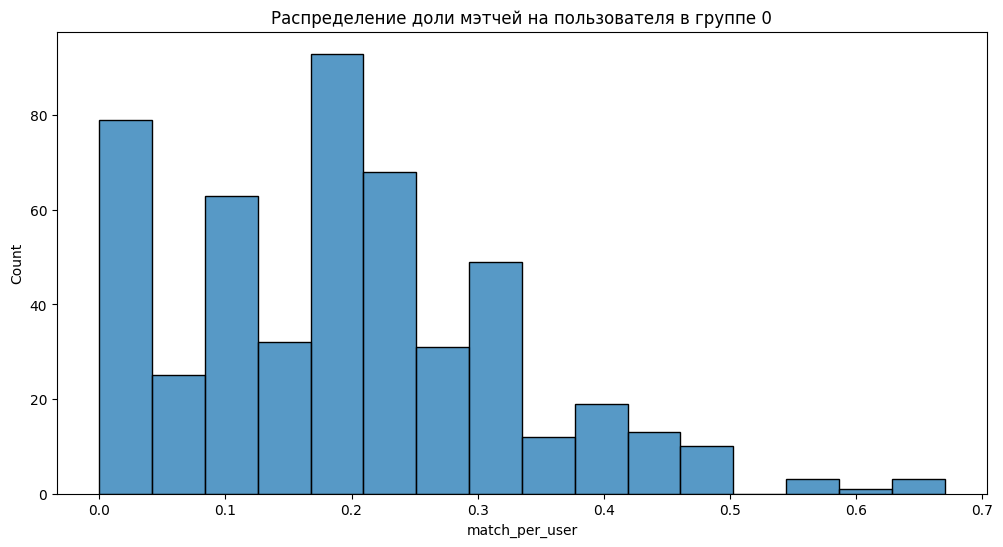

In [7]:
# распределение доля мэтчей на пользователя в группе 0
plt.figure(figsize=(12, 6))
sns.histplot(data=group0_match, x='match_per_user')
plt.title('Распределение доли мэтчей на пользователя в группе 0')
plt.show();

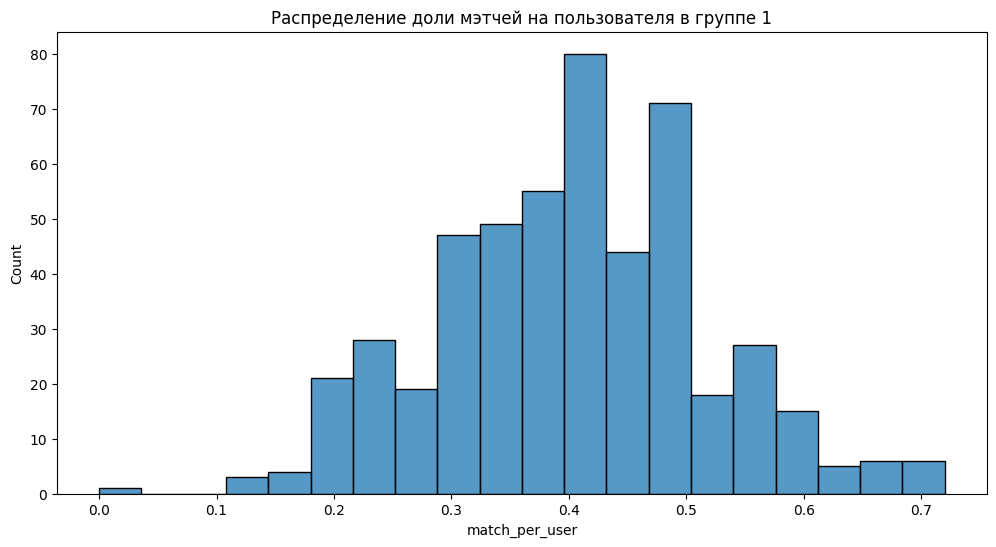

In [8]:
# распределение доля мэтчей на пользователя в группе 1
plt.figure(figsize=(12, 6))
sns.histplot(data=group1_match, x='match_per_user')
plt.title('Распределение доли мэтчей на пользователя в группе 1')
plt.show();

In [9]:
# проверка распределения на нормальность
stats.shapiro(group0_match.match_per_user) 

ShapiroResult(statistic=np.float64(0.9566227135043949), pvalue=np.float64(5.6554006522061654e-11))

In [10]:
stats.shapiro(group1_match.match_per_user) 

ShapiroResult(statistic=np.float64(0.9955126877692431), pvalue=np.float64(0.1622090368638478))

Распределение в двух группах не является нормальным.

In [11]:
# проверка дисперсий на гомогенность
stats.levene(group0_match.match_per_user, group1_match.match_per_user) 

LeveneResult(statistic=np.float64(10.035149464201396), pvalue=np.float64(0.001582466737859385))

Дисперсии не являются гомогенными.

В данном случае применим t-критерий Уэлча.

In [12]:
stats.ttest_ind(group0_match.match_per_user, group1_match.match_per_user, equal_var=False)

TtestResult(statistic=np.float64(-26.481431782585016), pvalue=np.float64(7.890669157070396e-117), df=np.float64(973.9371185920583))

Нулевая гипотеза о равенстве средних отклоняется. Взаимосвязь между средней долей мэтчей и типом алгоритма существует.

#### Гипотеза 2: существуют различия в среднем количестве действий на пользователя между алгоритмами.

- $H_0$: средние в группах не имеют различий
- $H_1$: средние в группах отличаются

In [13]:
# расчет среднего количество действий на пользователя в группе 0
mean_action_g0 = group0_match.is_match_count.mean()
print(f'Среднее количество действий на пользователя в группе 0: {mean_action_g0:.2f}')

Среднее количество действий на пользователя в группе 0: 9.56


In [14]:
# расчет среднего количество действий на пользователя в группе 1
mean_action_g1 = group1_match.is_match_count.mean()
print(f'Среднее количество действий на пользователя в группе 1: {mean_action_g1:.2f}')

Среднее количество действий на пользователя в группе 1: 19.48


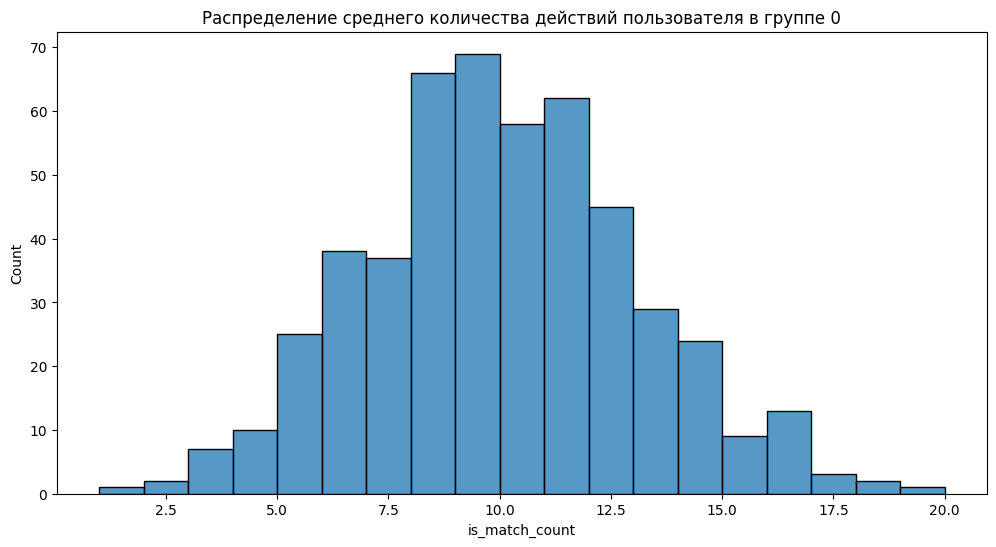

In [15]:
# распределение среднего количества действий на пользователя в группе 0
plt.figure(figsize=(12, 6))
sns.histplot(data=group0_match, x='is_match_count')
plt.title('Распределение среднего количества действий пользователя в группе 0')
plt.show();

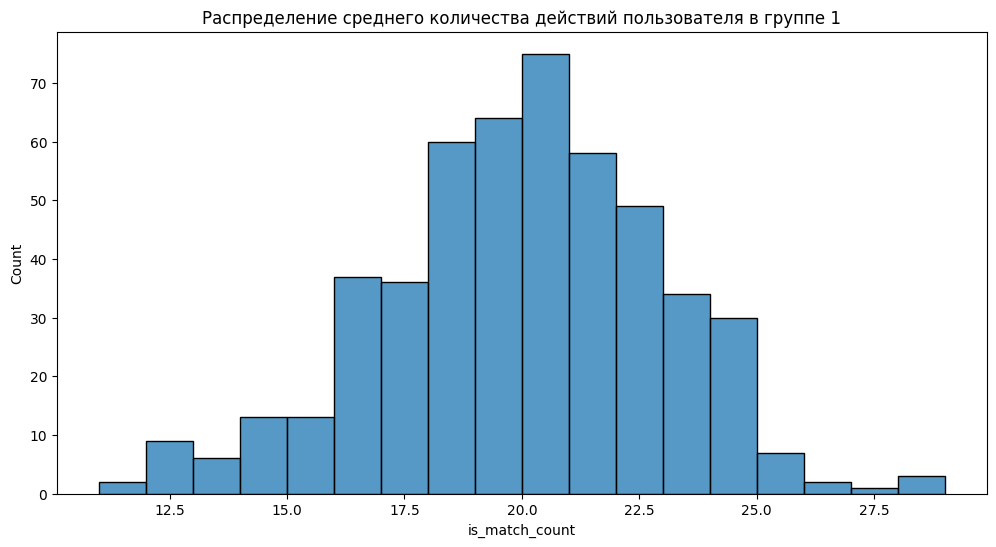

In [16]:
# распределение среднего количества действий на пользователя в группе 1
plt.figure(figsize=(12, 6))
sns.histplot(data=group1_match, x='is_match_count')
plt.title('Распределение среднего количества действий пользователя в группе 1')
plt.show();

In [17]:
# проверка распределения на нормальность
stats.shapiro(group0_match.is_match_count) 

ShapiroResult(statistic=np.float64(0.9884850177181765), pvalue=np.float64(0.0005573886960179489))

In [18]:
stats.shapiro(group1_match.is_match_count) 

ShapiroResult(statistic=np.float64(0.9839302855207089), pvalue=np.float64(2.542527067902603e-05))

Распределения в двух группах не являются нормальными.

In [19]:
stats.levene(group0_match.is_match_count, group1_match.is_match_count) 

LeveneResult(statistic=np.float64(0.4804538582845789), pvalue=np.float64(0.48837808141783545))

Дисперсии в группах не являются гомогенными.

In [20]:
stats.ttest_ind(group0_match.is_match_count, group1_match.is_match_count)

TtestResult(statistic=np.float64(-51.85383774946492), pvalue=np.float64(1.8942877064043142e-285), df=np.float64(998.0))

Нулевая гипотеза о равенстве средних отклоняется. Взаимосвязь между средним количеством действий на пользователя и типом алгоритма существует.

### Выводы
Результаты A/B-теста показали, что новая система улучшила метрики (долю мэтчей и активность клиентов в продукте).